# Calculate oxygen inventory in density space

## Load packages and define parameters

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import gsw
import cartopy
import cartopy.crs as ccrs

## Read in GOBAI-O$_2$ data file, select subregion in the North Atlantic, and calculate additional variables

GOBAI-O2 data are available at https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0259304


In [4]:
ds = xr.open_mfdataset('../../python/data/GOBAI-O2-v2.2.nc', chunks={'time': 12}).sel(lat=slice(45, 65), lon=slice(-62.5, -5.5))

# Calculate absolute salinity, conservative temperature, and potential density
ds['sa']  = gsw.SA_from_SP(ds['sal'], ds['pres'], ds['lon'], ds['lat']);
ds['ct'] = gsw.CT_from_t(ds['sa'], ds['temp'], ds['pres']);
ds['sigma'] = gsw.sigma0(ds['sa'], ds['ct']);

# Convert oxygen from umol/kg to mol/m3
ds['oxy_mol_m3'] = ds.oxy*(ds.sigma+1000)/1e6;
# Stack lat and lon dimension
ds_st = ds.stack(latlon=('lat', 'lon'))
z = -gsw.z_from_p(ds_st['pres'], ds_st['lat'])

In [5]:
# Density grid
ds_st = ds_st.assign_coords({'sig0_e': np.arange(24, 28.005, .01), 
                        'sig0': np.arange(24.005, 28, .01)})

## Data analysis

### Calculate oxygen on isopycnals, and layer thickness for the corresponding bin
Interpolate isopycnal depth onto bin edges (`sig0_e`) and oxygen onto bin center (`sig0`).

Function defined below allows `numpy.interp` to be applied along one dimension of a xarray DataArray without a for loop; code adapted from https://tutorial.xarray.dev/advanced/apply_ufunc/example-interp.html

In [7]:
def interp1d_np(data, x, xi, **kwargs):
    return np.interp(xi, x, data, **kwargs)

In [8]:
ds_st['iso_dpt'] = xr.apply_ufunc(
    interp1d_np, z, ds_st['sigma'], ds_st['sig0_e'],  
    input_core_dims=[['pres'], ['pres'], ['sig0_e']],
    output_core_dims=[['sig0_e']], 
    vectorize=True, dask='parallelized',
    kwargs={'left': 0, 'right': np.nan}, # optional arguments to pass to np.interp
    output_dtypes=[ds_st['oxy_mol_m3'].dtype],
).transpose('time', 'latlon', 'sig0_e')

ds_st['oxy_sig'] = xr.apply_ufunc(
    interp1d_np,  ds_st['oxy_mol_m3'], ds_st['sigma'], ds_st['sig0'],  
    input_core_dims=[['pres'], ['pres'], ['sig0']],
    output_core_dims=[['sig0']], 
    vectorize=True,  dask='parallelized',
    kwargs={'left': np.nan, 'right': np.nan},  # optional arguments to pass to np.interp
    output_dtypes=[ds_st['oxy_mol_m3'].dtype],
)

Layer thickness is calculated as the difference in depth of the two bounding isopycnals

In [10]:
ds_st['iso_thk'] = xr.DataArray(ds_st['iso_dpt'].diff(dim='sig0_e'), dims=['time', 'latlon', 'sig0'],
                               coords={'time': ds_st['time'], 
                                       'latlon': ds_st['latlon'],
                                       'sig1': ds_st['sig0']})
ds_st.load()

<xarray.Dataset>
Dimensions:     (time: 240, pres: 58, latlon: 1160, sig0_e: 401, sig0: 400)
Coordinates:
  * pres        (pres) float32 2.5 10.0 20.0 30.0 ... 1.8e+03 1.9e+03 1.975e+03
  * time        (time) datetime64[ns] 2004-01-15 2004-02-15 ... 2023-12-15
  * latlon      (latlon) object MultiIndex
  * lat         (latlon) float32 45.5 45.5 45.5 45.5 ... 64.5 64.5 64.5 64.5
  * lon         (latlon) float32 -62.5 -61.5 -60.5 -59.5 ... -8.5 -7.5 -6.5 -5.5
  * sig0_e      (sig0_e) float64 24.0 24.01 24.02 24.03 ... 27.98 27.99 28.0
  * sig0        (sig0) float64 24.0 24.02 24.03 24.04 ... 27.97 27.98 27.99 28.0
    sig1        (sig0) float64 24.0 24.02 24.03 24.04 ... 27.97 27.98 27.99 28.0
Data variables:
    oxy         (time, pres, latlon) float32 nan nan nan nan ... nan nan nan nan
    temp        (time, pres, latlon) float32 nan nan nan nan ... nan nan nan nan
    sal         (time, pres, latlon) float32 nan nan nan nan ... nan nan nan nan
    uncer       (time, pres, latlon) float32 nan nan nan nan ... nan nan nan nan
    sa          (time, pres, latlon) float64 nan nan nan nan ... nan nan nan nan
    ct          (time, pres, latlon) float64 nan nan nan nan ... nan nan nan nan
    sigma       (time, pres, latlon) float64 nan nan nan nan ... nan nan nan nan
    oxy_mol_m3  (time, pres, latlon) float64 nan nan nan nan ... nan nan nan nan
    iso_dpt     (time, latlon, sig0_e) float64 nan nan nan ... 358.3 398.0 423.7
    oxy_sig     (time, latlon, sig0) float64 nan nan nan ... 0.3068 0.3093
    iso_thk     (time, latlon, sig0) float64 nan nan nan ... 22.76 39.64 25.78

### Calculate October to April isopycnal oxygen change

In [12]:
# Group by year so datasets can be subtracted below with matching indices
ds_oct0 = ds_st.sel(time=ds_st['time'].dt.month.isin(10)).groupby('time.year').mean()
ds_apr0 = ds_st.sel(time=ds_st['time'].dt.month.isin(4)).groupby('time.year').mean()

# Align so year matches; e.g. 2005 is April 2005 - Oct 2004
ds_apr, ds_oct = xr.align(ds_apr0.sel(year=slice(2005, 2023)), 
                          ds_oct0.sel(year=slice(2004, 2022)), join='override')

In [13]:
# Calculate isopycnal oxygen change
iso_o2 = ((ds_apr['oxy_sig'] - ds_oct['oxy_sig'])*
          (ds_apr['iso_thk'] + ds_oct['iso_thk'])/2)


### Bin and plot data

In [15]:
# Bin for different density layers
sig_bnds = np.array([26.8, 27, 27.2, 27.3, 27.4, 27.5, 27.6, 27.7, 27.75]);
iso_o2_bin = iso_o2.groupby_bins('sig0', sig_bnds).sum()

#### Maps of spatial structure
Show the wintertime isopycnal oxygen change for specific layers between 26.8 kg m$^{-3}$ and 27.75 kg m$^{-3}$; Equivalent to Fig. 5 in the manuscript

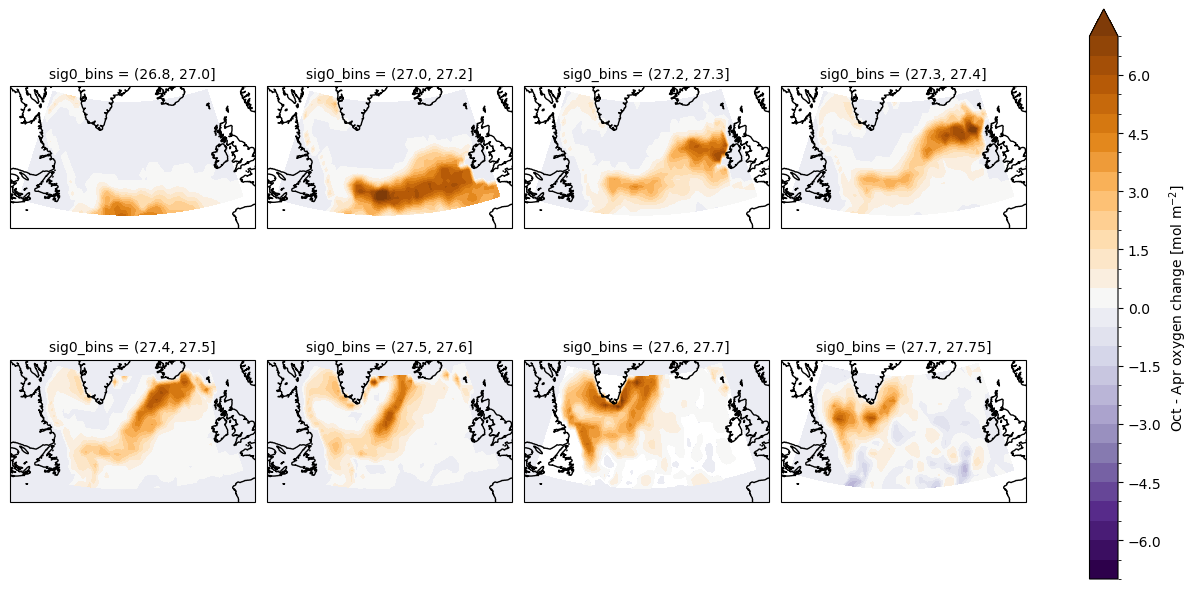

In [17]:
proj = ccrs.LambertConformal(
    central_longitude=-35.0, central_latitude=47.5)
fg1 = (iso_o2_bin.mean(dim='year').unstack()).plot.contourf(
    col="sig0_bins", col_wrap=4, 
    transform=ccrs.PlateCarree(),
    subplot_kws={'projection': proj},
    cmap='PuOr_r', vmin=-7, vmax=7, levels=29,
    cbar_kwargs={'label': 'Oct - Apr oxygen change [mol m$^{-2}$]'}
)
fg1.map(lambda: plt.gca().coastlines())

ax1 = fg1.axs; ax1[0, 0].set_extent([-62.5, -5, 40, 65])

#### Integrate in density space
Multiply change at each pixel by area of that grid cell, then bin into 0.05 kg m$^{-3}$ density bins and integrate within each bin. Line below corresponds to blue line in Fig. 4b

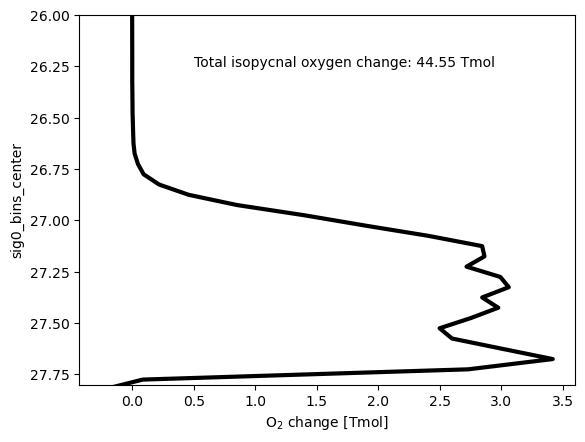

In [19]:
ar = 1852*60*1852*60.*np.cos(ds_st['latlon']['lat'].data/180*np.pi)
arn = xr.DataArray(ar, coords={'latlon': ds_st['latlon']},  
                          dims=['latlon'])
iso_o2_ar = iso_o2*arn
sig0_bins = np.arange(24, 28.005, .05)
iso_o2_SPNA = (iso_o2_ar.groupby_bins('sig0', sig0_bins).sum()
               .sum(dim='latlon').mean(dim='year'))/1e12

fig, ax = plt.subplots()
iso_o2_SPNA.plot(y = 'sig0_bins', color='k', linewidth=3)
ax.set_ylim([27.8, 26])
ax.set_xlabel('O$_2$ change [Tmol]')
plt.text(0.5, 26.25, 'Total isopycnal oxygen change: ' + 
                      '{:.2f}'.format((iso_o2_ar.sum(dim=['latlon', 'sig0']).mean(dim='year')/1e12)) + ' Tmol');